In [1]:
# =======Importing the libraries=======

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import Imputer,LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score,train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix,precision_score, recall_score, f1_score

from sklearn.decomposition import PCA
import statsmodels.formula.api as sm
from matplotlib.colors import ListedColormap

In [2]:
# =======Useful functions=======

def simplifyQTY(data):
    temp = data.replace('M3','').rstrip()
    temp = temp.replace('m3','').rstrip()
    return float(temp)

def normalizeConcSRC(data):
    if "ACC" in data:
        return "ACC"
    else:
        return data
    
def categoriesStrength(row):
    
    if 0 <= row['Comp. Strength in %'] < 100:
        return 0
    
    if 100 <= row['Comp. Strength in %']:
        return 1
    
def removeUnderscore(data):
    temp = data.replace('-','').rstrip()
    return temp

In [3]:
# =======Importing the dataset=======
dataset = pd.read_csv('cube.csv')

In [4]:
# =======Data Preporcessing==========

# removing last row as it contains Na in every col
dataset.drop(dataset.index[len(dataset)-1], inplace=True)    

# removing the metric unit and converting data into float
dataset['Qty.'] = dataset['Qty.'].apply(simplifyQTY)

# uniforming the data, for eg: T5 and T-5 are smiliar but different format, 
dataset['Concrete Grade'] = dataset['Concrete Grade'].apply(removeUnderscore)

dataset['Concrete Source'] = dataset['Concrete Source'].apply(normalizeConcSRC)

# making ranges(>100 & <100) from numeric data
dataset['category'] = dataset.apply (lambda row: categoriesStrength (row),axis=1)    

In [5]:
# sSperating dependent and independent variable in X and y respectively
X = dataset.iloc[:, :-2].values
y = dataset.iloc[:, -1].values

In [6]:
# taking care of missing data
imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imputer = imputer.fit(X[:, 2:9])
X[:, 2:9] = imputer.transform(X[:, 2:9])


In [7]:
# hot encoding of categorical  variable
labelencoder_X = LabelEncoder()
X[:, 0] = labelencoder_X.fit_transform(X[:, 0])
X[:, 1] = labelencoder_X.fit_transform(X[:, 1])
onehotencoder = OneHotEncoder(categorical_features = [0,1])
X = onehotencoder.fit_transform(X).toarray()

In [8]:
# to avoid dummy trap
X = np.delete(X, 0, 1) 
X = np.delete(X, 4, 1)

In [9]:
# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [10]:
# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [11]:
# ================================================ Data Modelling: Model 1 ======================================================

# Fitting Logistic Regression to the Training set
classifierLR = LogisticRegression(random_state = 0)
classifierLR.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [12]:
y_pred_LR = classifierLR.predict(X_test)

# Making the Confusion Matrix
confusion_matrix(y_test, y_pred_LR)

array([[276,   3],
       [  7, 177]], dtype=int64)

In [13]:
# Applying k-Fold Cross Validation
accuracies = cross_val_score(estimator = classifierLR, X = X_train, y = y_train, cv = 10)
print("Accuracy: {}%".format(round(accuracies.mean()*100, 2))) 
print("Accuracy STD: {}%".format(round(accuracies.std()*100, 2)))

Accuracy: 97.03%
Accuracy STD: 1.11%


In [14]:
# Applying Grid Search to find the best model and the best parameters
parameters = [{'C': [1, 10, 100, 1000]}]
grid_search = GridSearchCV(estimator = classifierLR,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10)
grid_search = grid_search.fit(X_train, y_train)

print("Grid Search result: Best Score = {} Best Param = {}".format(grid_search.best_score_,grid_search.best_params_))

Grid Search result: Best Score = 0.9832432432432432 Best Param = {'C': 100}


In [15]:
# Grid search suggests that if we take C=100 we can further increase the accuracy to 98.3%
# Lets initialize the model again with required param and see the changes in accuracy in following code

classifierLRWithParam = LogisticRegression(random_state = 0, C = 100)
classifierLRWithParam.fit(X_train, y_train)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [16]:
# Predicting the Test set results
y_pred_LRWithParam = classifierLRWithParam.predict(X_test)

# Making the Confusion Matrix
confusion_matrix(y_test, y_pred_LRWithParam)

array([[276,   3],
       [  7, 177]], dtype=int64)

In [17]:
accuracies = cross_val_score(estimator = classifierLRWithParam, X = X_train, y = y_train, cv = 10)
print("Final Accuracy: {}%".format(round(accuracies.mean()*100, 2))) 
print("Final Accuracy STD: {}%".format(round(accuracies.std()*100, 2)))
print("Precision: {}".format(round(precision_score(y_test, y_pred_LRWithParam), 2)))
print("Recall: {}".format(round(recall_score(y_test, y_pred_LRWithParam), 2)))
print("F1 Score: {}".format(round(f1_score(y_test, y_pred_LRWithParam), 2)))

Final Accuracy: 98.32%
Final Accuracy STD: 1.06%
Precision: 0.98
Recall: 0.96
F1 Score: 0.97


In [18]:
# Yes, we have achevied btter accuracy i.e 98% which is really good. Also other metrics are also mind blowing
# We can go further with dimensionality reduction to see if there is any scope of improvement.
# Intitution behind taking dimensionality in consideration is that not all feature help in getting good result sometimes, 
# so we will check if its possible to improve model by reducing the dimensionalty to 2

# ===========Applying PCA=================
pca = PCA(n_components = 2)
X_train_PCA = pca.fit_transform(X_train)
X_test_PCA = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_

# Fitting Logistic Regression to the Training set
classifierLR_PCA = LogisticRegression(random_state = 0)
classifierLR_PCA.fit(X_train_PCA, y_train)

# Predicting the Test set results
y_pred_PCA = classifierLR_PCA.predict(X_test_PCA)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_PCA)

array([[257,  22],
       [ 62, 122]], dtype=int64)

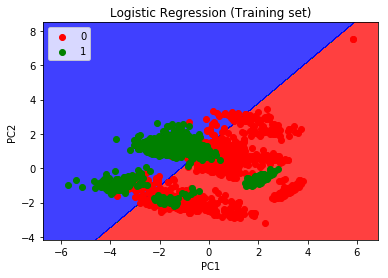

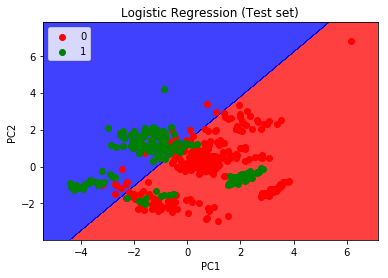

In [21]:
# As we have got dimensionality reduced to 2, that will be easy to visualize the data and prediction boundaries, 
# and also check if data is linearly seperable or not

# Visualising the Training set results
from matplotlib.colors import ListedColormap
X_set, y_set = X_train_PCA, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifierLR_PCA.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green', 'blue')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green', 'blue'))(i), label = j)
plt.title('Logistic Regression (Training set)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

# Visualising the Test set results
from matplotlib.colors import ListedColormap
X_set, y_set = X_test_PCA, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifierLR_PCA.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green', 'blue')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green', 'blue'))(i), label = j)
plt.title('Logistic Regression (Test set)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

In [22]:
# Actually, it has given worse accuracy, that means all feature are important in taking desicion in this particular case of ours
# Lets prove this by implementing Backward Elimination method and see if that removes any feature that is not participating significantly


# ============Backward elimination===============
import statsmodels.formula.api as sm
def backwardElimination(x, sl):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
    regressor_OLS.summary()
    return x
 
SL = 0.05
X_opt = X[:, 0:9]
X_Modeled = backwardElimination(X_opt, SL)

print("Number of features left after backward elimination: {}".format(len(X_Modeled[0])))

Number of features left after backward elimination: 9


In [23]:
# Everything is as it is, let probe more into it. 
# Lets print out the regression summary and check P value to determin significance of all features
# SL has been selected to 0.05


regressor_OLS = sm.OLS(y, X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     935.0
Date:                Wed, 16 May 2018   Prob (F-statistic):               0.00
Time:                        22:17:50   Log-Likelihood:                -412.39
No. Observations:                2313   AIC:                             842.8
Df Residuals:                    2304   BIC:                             894.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.6882      0.040    -17.098      0.000      -0.767      -0.609
x2            -0.7172      0.028    -25.797      0.000      -0.772      -0.663
x3            -1.0828      0.036    -30.392      0.000      -1.153      -1.013
x4            -0.0983      0.015     -6.552      0.000      -0.128      -0.069
x5            -0.0001   4.35e-05     -2.998      0.003      -0.000   -4.51e-05
x6             0.0165      0.001     24.044      0.000       0.015       0.018
x7            -0.0757      0.019     -3.909      0.000      -0.114      -0.038
x8             0.0003   6.43e-05      4.049      0.000       0.000       0.000
x9             0.0008    2.9e-05     29.147      0.000       0.001       0.001
==============================================================================
Omnibus:                       72.336   Durbin-Watson:                   1.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.325
Skew:                          -0.322   Prob(JB):                     6.03e-23
Kurtosis:                       3.805   Cond. No.                     2.39e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.39e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
# As we can see that p value of all feature is less than the significance level. Hence proved

In [25]:
# ================================================ Data Modelling: Model 2 ======================================================
# As we have selected a linear model before, lets try with non linear model, eg: Kernel SVM(Gaussian)
# data has been imported and cleaned aready. we will start with modelling straightly

# Fitting Kernel SVM to the Training set
classifierSVM = SVC(kernel = 'rbf', random_state = 0)
classifierSVM.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [26]:
# Predicting the Test set results
y_pred_SVM = classifierSVM.predict(X_test)

# Making the Confusion Matrix
confusion_matrix(y_test, y_pred_SVM)

array([[272,   7],
       [ 10, 174]], dtype=int64)

In [27]:
# Applying k-Fold Cross Validation
accuracies = cross_val_score(estimator = classifierSVM, X = X_train, y = y_train, cv = 10)
print("Accuracy: {}%".format(round(accuracies.mean()*100, 2))) 
print("Accuracy STD: {}%".format(round(accuracies.std()*100, 2)))

Accuracy: 96.27%
Accuracy STD: 1.44%


In [28]:
# Applying Grid Search to find the best model and the best parameters
parameters = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
              {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]
grid_search = GridSearchCV(estimator = classifierSVM,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10)
grid_search = grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Grid Search result: Best Score = {} Best Param = {}".format(grid_search.best_score_,grid_search.best_params_))

Grid Search result: Best Score = 0.9886486486486487 Best Param = {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}


In [29]:
# Grid search suggests that if we take C=100 we can further increase the accuracy to 98.87%
# Lets initialize the model again with required param and see the changes in accuracy in following code

classifierSVMwithParam = SVC(kernel = 'rbf', random_state = 0, C = 100, gamma = 0.1)
classifierSVMwithParam.fit(X_train, y_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [30]:
# Predicting the Test set results
y_pred_SVMwithParam = classifierSVMwithParam.predict(X_test)

# Making the Confusion Matrix
confusion_matrix(y_test, y_pred_SVMwithParam)

array([[278,   1],
       [  4, 180]], dtype=int64)

In [31]:
accuracies = cross_val_score(estimator = classifierSVMwithParam, X = X_train, y = y_train, cv = 10)
print("Final Accuracy: {}%".format(round(accuracies.mean()*100, 2))) 
print("Final Accuracy STD: {}%".format(round(accuracies.std()*100, 2)))
print("Precision: {}".format(round(precision_score(y_test, y_pred_SVMwithParam), 2)))
print("Recall: {}".format(round(recall_score(y_test, y_pred_SVMwithParam), 2)))
print("F1 Score: {}".format(round(f1_score(y_test, y_pred_SVMwithParam), 2)))

Final Accuracy: 98.87%
Final Accuracy STD: 0.7%
Precision: 0.99
Recall: 0.98
F1 Score: 0.99


In [32]:
# ================================================ Data Modelling: Model 3 ======================================================

# Fitting Random Forest Classification to the Training set
classifierRM = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifierRM.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [33]:
# Predicting the Test set results
y_pred_RM = classifierRM.predict(X_test)

# Making the Confusion Matrix
confusion_matrix(y_test, y_pred_RM)

# As we can see that accuracy before Grid Search by looking at Confusion Matrix is already bery high so there is no need of 
# doing grid search and lets set this to our final accuracy

array([[278,   1],
       [  5, 179]], dtype=int64)

In [34]:
# Applying k-Fold Cross Validation
accuracies = cross_val_score(estimator = classifierRM, X = X_train, y = y_train, cv = 10)
print("Final Accuracy: {}%".format(round(accuracies.mean()*100, 2))) 
print("Final Accuracy STD: {}%".format(round(accuracies.std()*100, 2)))
print("Precision: {}".format(round(precision_score(y_test, y_pred_RM), 2)))
print("Recall: {}".format(round(recall_score(y_test, y_pred_RM), 2)))
print("F1 Score: {}".format(round(f1_score(y_test, y_pred_RM), 2)))

Final Accuracy: 99.24%
Final Accuracy STD: 0.43%
Precision: 0.99
Recall: 0.97
F1 Score: 0.98
